<a href="https://colab.research.google.com/github/yopi1838/trading-api-yopi-kevin/blob/master/LSTM_stocks3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
#store csv as dataframe
df = pd.read_csv("AAL-pricehistory.csv")
df = df.sort_values('Date')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'], inplace=True)
df.head

<bound method NDFrame.head of                Low   High  Close    Open
Date                                    
2005-09-27  19.100  21.40  19.30  21.050
2005-09-28  19.200  20.53  20.50  19.300
2005-09-29  20.100  20.58  20.21  20.400
2005-09-30  20.180  21.05  21.01  20.260
2005-10-03  20.900  21.75  21.50  20.900
...            ...    ...    ...     ...
2021-01-12  14.880  15.43  15.38  15.075
2021-01-13  15.110  15.63  15.53  15.290
2021-01-14  15.820  16.60  16.44  15.830
2021-01-15  15.735  16.28  15.76  16.170
2021-01-19  15.890  16.27  15.97  15.990

[3854 rows x 4 columns]>

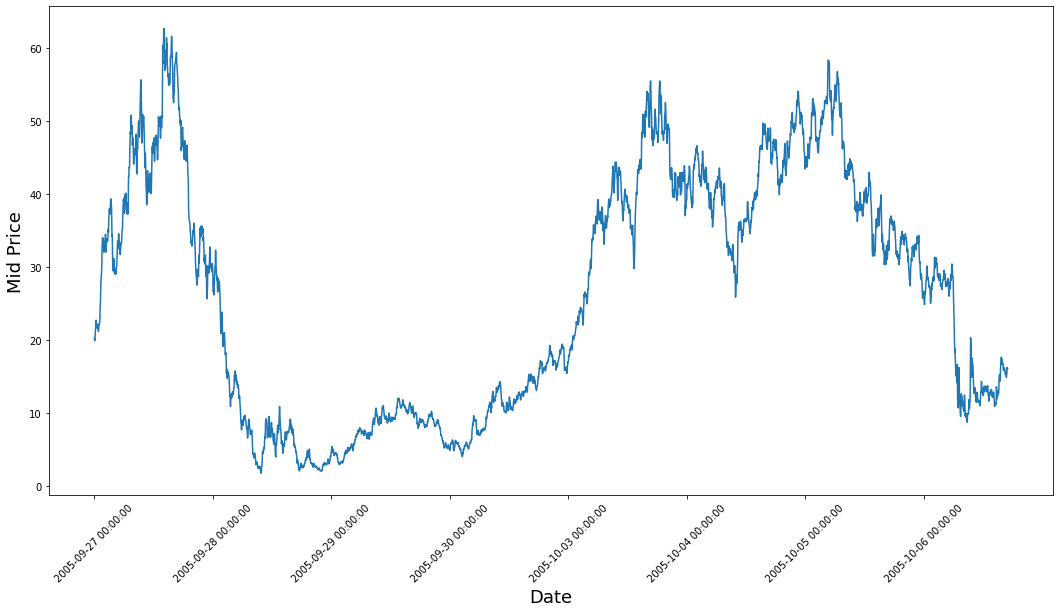

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df.index,rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [ ]:
#Split the dataset for train and test
#First calculate the mid prices from high and low
high_p = df.loc[:,"High"]
low_p = df.loc[:,"Low"]
high_prices = high_p.values
low_prices = low_p.values
mid_prices = (high_prices + low_prices) / 2.0
df['Mid'] = mid_prices
print(mid_prices)
print(len(mid_prices))

[20.25   19.865  20.34   ... 16.21   16.0075 16.08  ]
3854


In [ ]:
#Separate the train and test data (70%, 20%, 10%)
column_indices = {name: i for i, name in enumerate(df.columns)}
n=len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]
print(num_features)
print(column_indices)
print(len(train_df))
print(len(val_df))
print(len(test_df))

5
{'Low': 0, 'High': 1, 'Close': 2, 'Open': 3, 'Mid': 4}
2697
771
386


In [ ]:
#normalize the data by substracting against train_data mean and stddev
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
train_df.head

<bound method NDFrame.head of                  Low      High     Close      Open       Mid
Date                                                        
2005-09-27 -0.199509 -0.114226 -0.212519 -0.109472 -0.156257
2005-09-28 -0.193456 -0.165357 -0.140985 -0.213762 -0.179221
2005-09-29 -0.138971 -0.162418 -0.158272 -0.148208 -0.150888
2005-09-30 -0.134128 -0.134796 -0.110583 -0.156551 -0.134485
2005-10-03 -0.090541 -0.093657 -0.081373 -0.118411 -0.092134
...              ...       ...       ...       ...       ...
2016-06-08  0.594753  0.565750  0.574952  0.580630  0.580112
2016-06-09  0.596569  0.601600  0.628007  0.557984  0.599200
2016-06-10  0.620179  0.595676  0.612508  0.590761  0.607825
2016-06-13  0.559640  0.566925  0.532628  0.602084  0.563410
2016-06-14  0.461568  0.506979  0.446787  0.531763  0.484673

[2697 rows x 5 columns]>

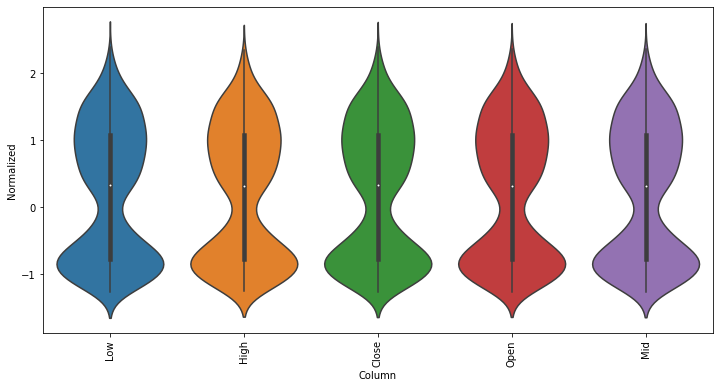

In [ ]:
#Peek at the distribution value
import seaborn as sns
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name ='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
"""
In this part we will create WindowGenerator class that will:
1. Handle indexes and offsets
2. Split windows of features into (features, labels) pairs
3. Plot content of the resulting windows
4. Generate batches of windows using tf.data.Dataset
"""
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, 
               train_df=train_df, val_df=val_df, test_df=test_df, 
               label_columns=None):
    #Store the data
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    #Work the label column indices
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    #Work the window parameters
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift #how much of the input shall shift (this includes the data that are considered as labels)

    self.total_window_size = input_width + shift

    #define input indices
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    #define label indices
    self.label_start = self.total_window_size - self.label_width 
    self.label_slice = slice(self.label_start, None)  #Because label can be more than 1 step ahead
    self.label_indices = np.arange(self.total_window_size)[self.label_slice]
    
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Mid'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Mid']

In [ ]:
"""
split_window function will separate the consecutive inputs and outputs feed into the function
"""
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.label_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns], 
        axis = -1)
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
#Test the class
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size]),
                           np.array(train_df[300:300+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (4, 7, 5)
Inputs shape: (4, 6, 5)
labels shape: (4, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
"""
plot function is introduced to show visualization of the split window
"""
def plot(self, model=None, plot_col='Mid', max_subplots=6):
  inputs, labels = self.example
  plt.figure(figsize=(12,32))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n,1,n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n,:,plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    
    if label_col_index is None:
      continue
    
    plt.scatter(self.label_indices, labels[n,:,label_col_index],
                marker='X', edgecolors='k', label='Labels', c='#2ca02c', s=32)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n,:,label_col_index],
                  marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=32)
    if n == 0:
      plt.legend()
  
  plt.xlabel('Date')

WindowGenerator.plot = plot

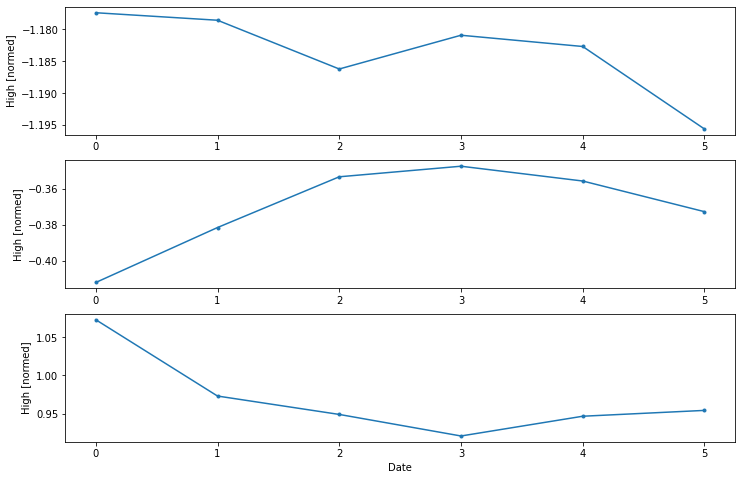

In [ ]:
w2.plot(plot_col='High')

In [ ]:
"""
make_dataset method is used to take the time series df and turn it into tf.data.Dataset with (input_window, label_window) pairs
This method utilizes tf.keras.preprocessing.timeseries_dataset_from_array function
"""
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32) #Because train_df is still DataFrame object
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None, #Target is set to none so that ds will yield input data
      sequence_length = self.total_window_size, #includes the label_width
      sequence_stride = 1,
      shuffle=True,
      batch_size=32,
      )
  ds = ds.map(self.split_window) #create dataset for all of the split inputs and labels

  return ds

WindowGenerator.make_dataset = make_dataset #add function as method to class WindowGenerator

In [ ]:
"""
Since train_df, test_df, and val_df is already added to WindowGenerator class,
we now make them as datasets instead of DataFrame. use @property decorator
"""
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    #No example batch was found, get one from .train dataset
    result = next(iter(self.train))
    #cache it to self._example
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
w2.train.element_spec #element_spec is property that tells you the structure, dtypes, and shapes of the said dataset elements

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
#Iterate the methods over a Dataset:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Input shape (batch, time, features) : {example_inputs.shape}')
  print(f'Labels shape (batch, time, features) : {example_labels.shape}')

Input shape (batch, time, features) : (32, 6, 5)
Labels shape (batch, time, features) : (32, 1, 1)


Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33 

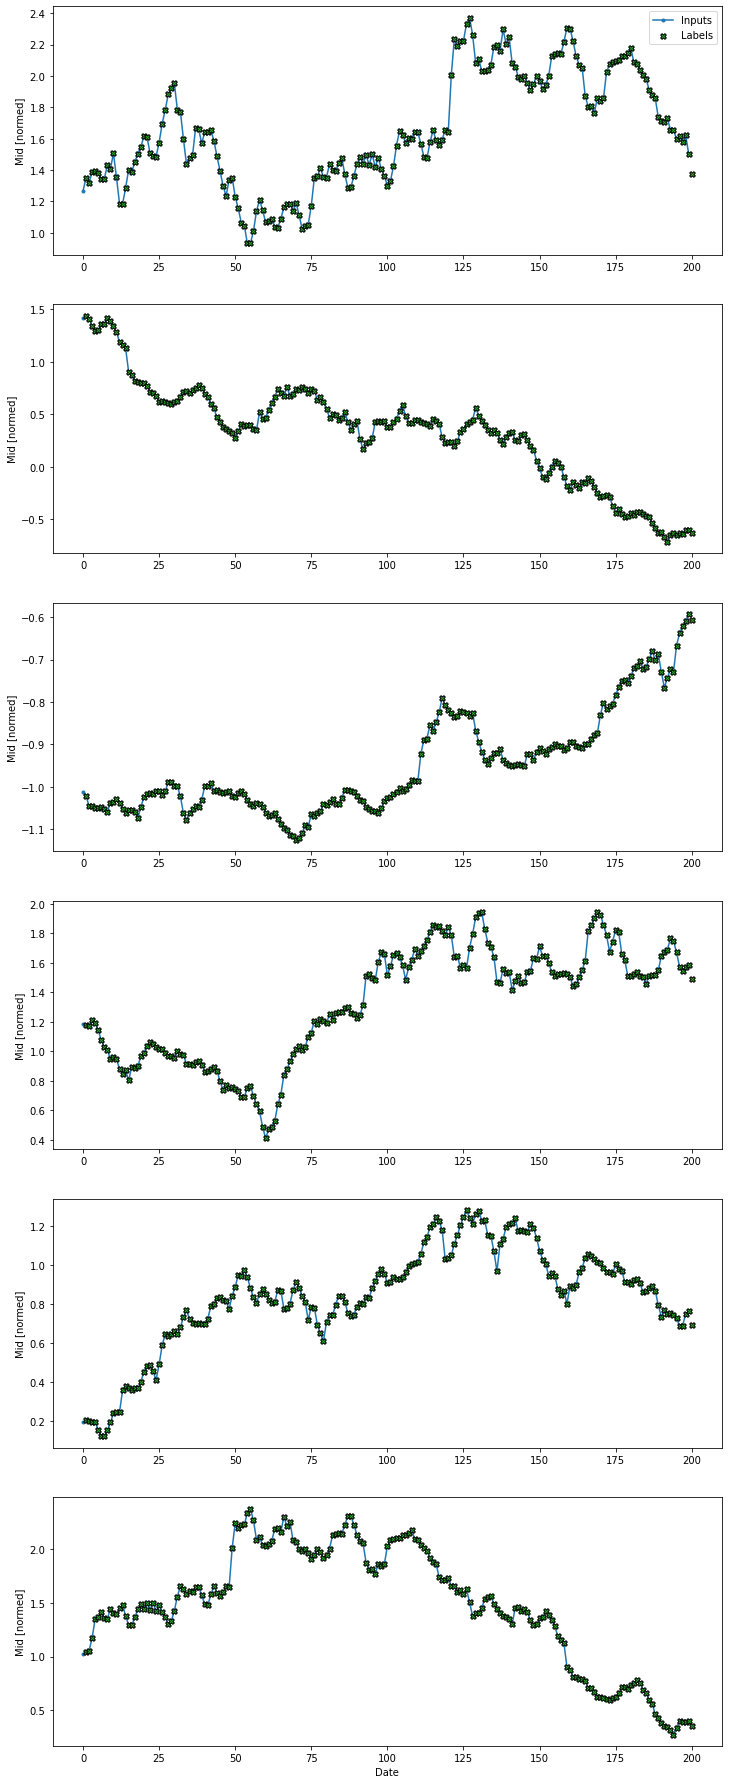

In [ ]:
#We now create a multiple time step predictions for our data
OUT_STEPS = 1
window = WindowGenerator(input_width=200,
                               label_width=200,
                               shift=OUT_STEPS,
                               label_columns=['Mid'])
window.plot()
window

In [ ]:
#Create a model trainer function including EarlyStopping, compile, and fit
LOSS=tf.losses.MeanSquaredError()
METRICS = tf.metrics.MeanAbsoluteError()
OPTIMIZERS = tf.optimizers.Adam()
MAX_EPOCHS = 50
def compile_and_fit(model, window, patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=LOSS,
                optimizer=OPTIMIZERS,
                metrics=[METRICS])
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
#We can use RNN for long history of inputs, if it's relevant to the predictions the model is making.
units = 32
model = tf.keras.Sequential([
                             tf.keras.layers.LSTM(units, return_sequences=True),
                             tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros)
])
print('Input shape: ', window.example[0].shape)
print('Output shape: ', model(window.example[0]).shape)

Input shape:  (32, 200, 5)
Output shape:  (32, 200, 1)


In [ ]:
history = compile_and_fit(model, window)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}

18/18 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0433


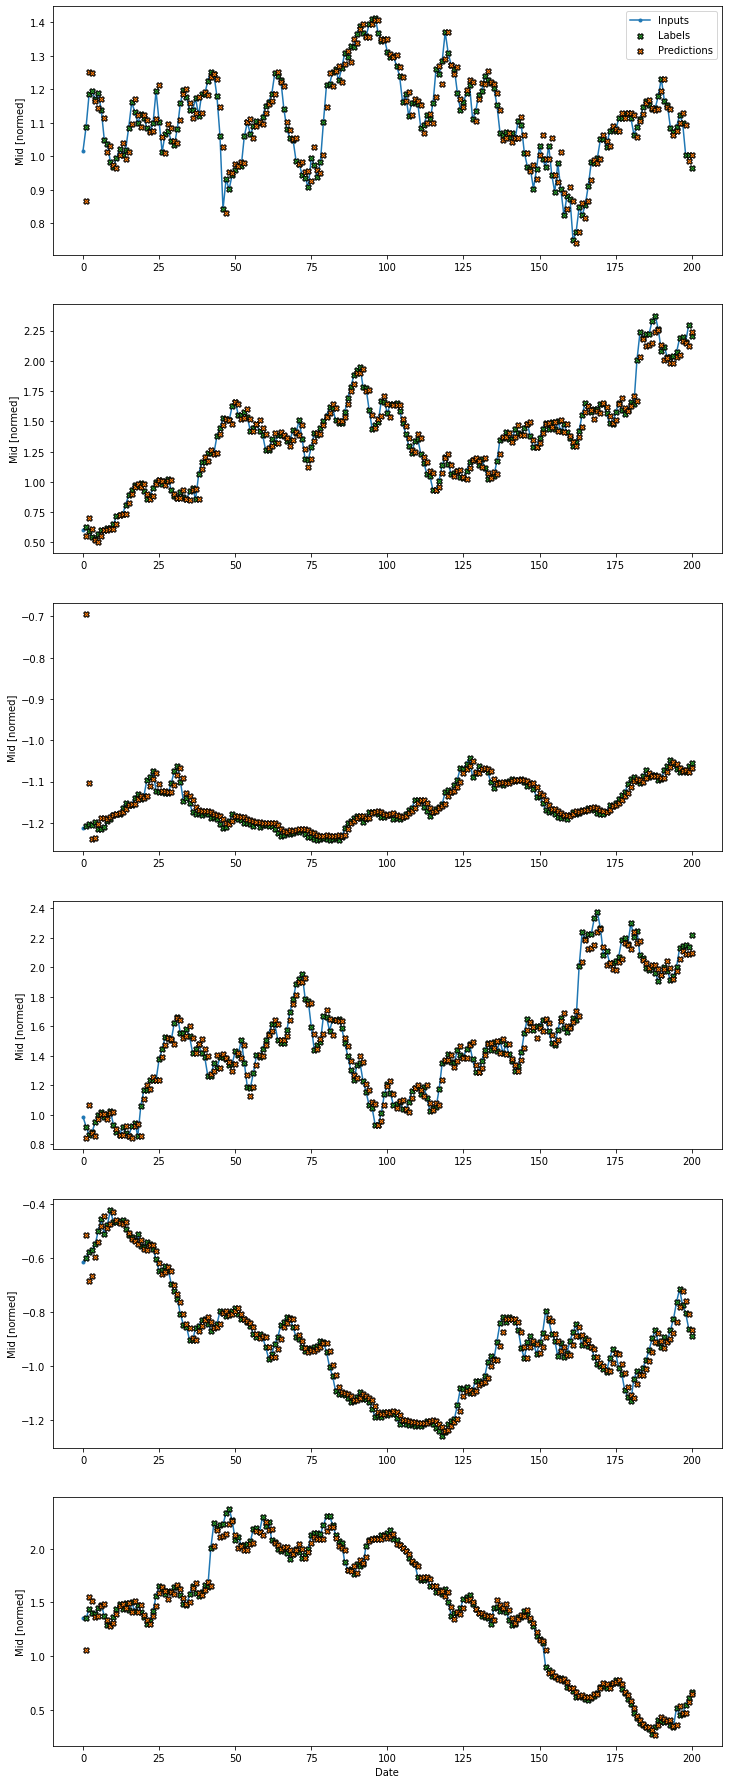

In [ ]:
multi_val_performance['LSTM'] = model.evaluate(window.val)
multi_performance['LSTM'] = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)